In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
from imp import reload

#import DCA stuff
from dca import analysis
from dca import data_util
from dca import plotting

#import FastKF (todo: import installable package once FastKF is finalized)
import sys
sys.path.append("/Users/davidclark/Projects/FastKF/fastkf")
import fastkf

In [2]:
#load datasets
m1 = data_util.load_sabes_data("../data/sabes/indy_20160627_01.mat")
X_m1, Y_m1 = m1["M1"], m1["cursor"]

hc = data_util.load_kording_paper_data("../data/kording_paper/example_data_hc.pickle")
X_hc, Y_hc = hc["neural"], hc["loc"]

X_weather = data_util.load_weather_data("../data/weather/temperature.csv")

X_accel = data_util.load_accel_data("../data/accel/sub_19.csv")

#set analysis params 
num_cv_folds = 5
dsets = [X_m1, X_hc, X_weather, X_accel]
dset_names = ["m1", "hc", "weather", "accel"]
dim_vals = np.array([[5, 10, 15, 25],
                     [10, 15, 25, 30],
                     [3, 4, 5, 6],
                     [3, 4, 5, 6]])
offset_vals = np.array([0, 5, 10, 15])
decoding_window = 3
T_pi_vals = np.arange(1, 11)

In [5]:
#create .mat file for import by MATLAB for GPFA 

gpfa_dsets = []
for i in range(len(dsets)):
    X = dsets[i]
    min_std=1e-6
    good_cols = (X.std(axis=0) > min_std)
    X = X[:, good_cols]
    cv = data_util.CrossValidate(X, X, num_cv_folds, stack=False)
    gpfa_data = []
    for X_train, X_test, _, _, _ in cv:
        X_mean = np.concatenate(X_train).mean(axis=0, keepdims=True)
        X_train_ctd = [Xi - X_mean for Xi in X_train]
        X_test_ctd = X_test - X_mean
        gpfa_data.append((X_train, X_test))
    gpfa_dsets.append(gpfa_data)
gpfa_dict = {}
gpfa_dict["data"] = gpfa_dsets
gpfa_dict["dsetNames"] = dset_names
gpfa_dict["dimVals"] = dim_vals
savemat("gpfa_data/gpfa_input.mat", gpfa_dict)

In [3]:
#load GPFA results from MATLAB

gpfa_output = loadmat("/Users/davidclark/Projects/gpfa_v0203/DC_JL_results/results.mat")["results"]

In [7]:
#score GPFA latents

reload(analysis)
def run_analysis_gpfa(gpfa_results, Y, offset_vals, decoding_window):
    #gpfa_results = (num_folds, num_dims, 4)
    num_cv_folds = gpfa_results.shape[0]
    num_dims = gpfa_results.shape[1]
    results = np.zeros((num_cv_folds, num_dims, len(offset_vals), 2))
    cv = data_util.CrossValidate(np.zeros_like(Y), Y, num_cv_folds, stack=True)
    for X_train, X_test, Y_train, Y_test, fold_idx in cv:
        Y_mean = np.concatenate(Y_train).mean(axis=0, keepdims=True)
        Y_train_ctd = [Yi - Y_mean for Yi in Y_train]
        Y_test_ctd = Y_test - Y_mean
        #"trialize" the Y-values as we did in the GPFA MATLAB script
        Y_train_trials, Y_test_trials = [], []
        train_trial_fmt = [X.T for X in gpfa_results[fold_idx, 0, 0][0, :]]
        test_trial_fmt = [X.T for X in gpfa_results[fold_idx, 0, 2][0, :]]
        i = 0
        for trial in train_trial_fmt:
            Y_train_trials.append(Y_train_ctd[i:i+len(trial)])
            i += len(trial)
        i = 0
        for trial in test_trial_fmt:
            Y_test_trials.append(Y_test_ctd[i:i+len(trial)])
            i += len(trial)
        for dim_idx in range(num_dims):
            #get GPFA outputs (smoothing + filtering)
            X_train_smooth_trials = [X.T for X in gpfa_results[fold_idx, dim_idx, 0][0, :]]
            X_train_filter_trials = [X.T for X in gpfa_results[fold_idx, dim_idx, 1][0, :]]
            X_test_smooth_trials = [X.T for X in gpfa_results[fold_idx, dim_idx, 2][0, :]]
            X_test_filter_trials = [X.T for X in gpfa_results[fold_idx, dim_idx, 3][0, :]]
            #loop over offset vals
            for offset_idx in range(len(offset_vals)):
                offset = offset_vals[offset_idx]
                #do the r2 evals
                r2_gpfa_smooth = analysis.linear_decode_r2(X_train_smooth_trials, Y_train_trials, X_test_smooth_trials, Y_test_trials,
                                                  decoding_window=decoding_window, offset=offset)
                r2_gpfa_filter = analysis.linear_decode_r2(X_train_filter_trials, Y_train_trials, X_test_filter_trials, Y_test_trials,
                                                  decoding_window=decoding_window, offset=offset)
                results[fold_idx, dim_idx, offset_idx, 0] = r2_gpfa_smooth
                results[fold_idx, dim_idx, offset_idx, 1] = r2_gpfa_filter
    return results

In [8]:
#run the above fn to get GPFA results


print("M1")
gpfa_results_m1 = run_analysis_gpfa(gpfa_output[0], Y_m1, offset_vals, decoding_window)

print("HC")
gpfa_results_hc = run_analysis_gpfa(gpfa_output[1], Y_hc, offset_vals, decoding_window)

print("weather")
gpfa_results_weather = run_analysis_gpfa(gpfa_output[2], X_weather, offset_vals, decoding_window)

print("accel.")
gpfa_results_accel = run_analysis_gpfa(gpfa_output[3], X_accel, offset_vals, decoding_window)


M1
HC
weather
accel.


In [9]:
#load pre-computed DCA results (also includes PCA and SFA)

dca_results = np.load("/Users/davidclark/Projects/DynamicalComponentsAnalysis/data/results/real_data.npz", "r")
list(dca_results.keys())

#substitute the GPFA smoothing/filtering results where PCA used to be (plotting 'hack')

M1_results_sm = np.copy(dca_results["M1_results"])
M1_results_fi = np.copy(dca_results["M1_results"])
M1_results_sm[:, :, :, 0] = gpfa_results_m1[:, :, :, 0]
M1_results_fi[:, :, :, 0] = gpfa_results_m1[:, :, :, 1]

HC_results_sm = np.copy(dca_results["HC_results"])
HC_results_fi = np.copy(dca_results["HC_results"])
HC_results_sm[:, :, :, 0] = gpfa_results_hc[:, :, :, 0]
HC_results_fi[:, :, :, 0] = gpfa_results_hc[:, :, :, 1]

weather_results_sm = np.copy(dca_results["weather_results"])
weather_results_fi = np.copy(dca_results["weather_results"])
weather_results_sm[:, :, :, 0] = gpfa_results_weather[:, :, :, 0]
weather_results_fi[:, :, :, 0] = gpfa_results_weather[:, :, :, 1]

accel_results_sm = np.copy(dca_results["accel_results"])
accel_results_fi = np.copy(dca_results["accel_results"])
accel_results_sm[:, :, :, 0] = gpfa_results_accel[:, :, :, 0]
accel_results_fi[:, :, :, 0] = gpfa_results_accel[:, :, :, 1]

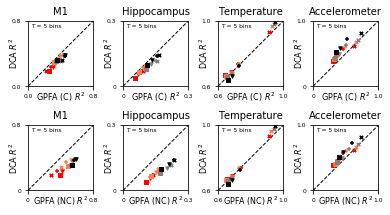

In [10]:
#plot GPFA vs. DCA results

reload(plotting)
fig, axes = plotting.decoding_fix_axes(fig_width=5.5, fig_height=2.7,
                                       wpad_mid=.075, hpad_mid=.2,
                                       wpad_left=.09, wpad_right=.025,
                                       hpad_bot=.12)

loc = "lower right"
bbox_to_anchor = (1.2, -.1)

plotting.scatter_r2_vals(M1_results_fi, 4, dim_vals[0], offset_vals, T_pi_vals, min_val=0., max_val=.8,
                         title='M1', timestep_units='ms', timestep=50, ax=axes[0], pca_label="GPFA (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(M1_results_sm, 4, dim_vals[0], offset_vals, T_pi_vals, min_val=0, max_val=.8,
                         title='M1', timestep_units='ms', timestep=50, ax=axes[4], pca_label="GPFA (NC)",
                         legend=False)

plotting.scatter_r2_vals(HC_results_fi, 4, dim_vals[1], offset_vals, T_pi_vals, min_val=0, max_val=.3,
                         title='Hippocampus', timestep_units='ms', timestep=50, ax=axes[1], pca_label="GPFA (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(HC_results_sm, 4, dim_vals[1], offset_vals, T_pi_vals, min_val=0, max_val=.3,
                         title='Hippocampus', timestep_units='ms', timestep=50, ax=axes[5], pca_label="GPFA (NC)",
                         legend=False)

plotting.scatter_r2_vals(weather_results_fi, 4, dim_vals[2], offset_vals, T_pi_vals, min_val=.6, max_val=1.,
                         title='Temperature', timestep_units='ms', timestep=50, ax=axes[2], pca_label="GPFA (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(weather_results_sm, 4, dim_vals[2], offset_vals, T_pi_vals, min_val=.6, max_val=1.,
                         title='Temperature', timestep_units='ms', timestep=50, ax=axes[6], pca_label="GPFA (NC)",
                         legend=False)

plotting.scatter_r2_vals(accel_results_fi, 4, dim_vals[3], offset_vals, T_pi_vals, min_val=0, max_val=1.,
                         title='Accelerometer', timestep_units='ms', timestep=50, ax=axes[3], pca_label="GPFA (C)",
                          legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(accel_results_sm, 4, dim_vals[3], offset_vals, T_pi_vals, min_val=0, max_val=1.,
                         title='Accelerometer', timestep_units='ms', timestep=50, ax=axes[7], pca_label="GPFA (NC)",
                         legend=False)
#plt.savefig("figures/gpfa_filt_smooth.pdf", bbox_inches="tight")



In [11]:
#score KF latents

reload(fastkf)
def run_analysis_kf(X, Y, dim_vals, offset_vals, num_cv_folds, decoding_window,
                    filename, verbose=False, min_std=1e-6):
    results = np.zeros((num_cv_folds, len(dim_vals), len(offset_vals), 2))
    good_cols = (X.std(axis=0) > min_std)
    X = X[:, good_cols]
    cv = analysis.CrossValidate(X, Y, num_cv_folds, stack=False)
    for X_train, X_test, Y_train, Y_test, fold_idx in cv:
        if verbose:
            print("fold", fold_idx + 1, "of", num_cv_folds)
        X_mean = np.concatenate(X_train).mean(axis=0, keepdims=True)
        X_train_ctd = [Xi - X_mean for Xi in X_train]
        X_test_ctd = X_test - X_mean
        Y_mean = np.concatenate(Y_train).mean(axis=0, keepdims=True)
        Y_train_ctd = [Yi - Y_mean for Yi in Y_train]
        Y_test_ctd = Y_test - Y_mean
        for dim_idx in range(len(dim_vals)):
            dim = dim_vals[dim_idx]
            if verbose:
                print("dim", dim_idx + 1, "of", len(dim_vals))
            kf = fastkf.KalmanFilter()
            kf.fit(X_train_ctd, dim, n_iter=200, print_interval=20)
            x_hat_train_sm = kf.transform(X_train_ctd)
            x_hat_test_sm = kf.transform([X_test_ctd])
            x_hat_train_fi = kf.transform_causal(X_train_ctd)
            x_hat_test_fi = kf.transform_causal([X_test_ctd])
            for offset_idx in range(len(offset_vals)):
                offset = offset_vals[offset_idx]
                r2_kf_smooth = analysis.linear_decode_r2(x_hat_train_sm, Y_train_ctd, x_hat_test_sm, Y_test_ctd,
                                                         decoding_window=decoding_window, offset=offset)
                r2_kf_filter = analysis.linear_decode_r2(x_hat_train_fi, Y_train_ctd, x_hat_test_fi, Y_test_ctd,
                                                         decoding_window=decoding_window, offset=offset)
                results[fold_idx, dim_idx, offset_idx, 0] = r2_kf_smooth
                results[fold_idx, dim_idx, offset_idx, 1] = r2_kf_filter
        np.save(filename, results)
    return results

In [64]:
#run the above fn to get KF results

"""
results_m1 = run_analysis_kf(X_m1, Y_m1, dim_vals[0], offset_vals, num_cv_folds,
                             decoding_window, "kf_data/M1.npy", verbose=True)

results_hc = run_analysis_kf(X_hc, Y_hc, dim_vals[1], offset_vals, num_cv_folds,
                             decoding_window, "kf_data/HC.npy", verbose=True)

results_weather = run_analysis_kf(X_weather, X_weather, dim_vals[2], offset_vals, num_cv_folds,
                             decoding_window, "kf_data/weather.npy", verbose=True)


results_accel = run_analysis_kf(X_accel, X_accel, dim_vals[3], offset_vals, num_cv_folds,
                             decoding_window, "kf_data/accel.npy", verbose=True)

"""



'\nresults_m1 = run_analysis_kf(X_m1, Y_m1, dim_vals[0], offset_vals, num_cv_folds,\n                             decoding_window, "kf_data/M1.npy", verbose=True)\n\nresults_hc = run_analysis_kf(X_hc, Y_hc, dim_vals[1], offset_vals, num_cv_folds,\n                             decoding_window, "kf_data/HC.npy", verbose=True)\n\nresults_weather = run_analysis_kf(X_weather, X_weather, dim_vals[2], offset_vals, num_cv_folds,\n                             decoding_window, "kf_data/weather.npy", verbose=True)\n\n\nresults_accel = run_analysis_kf(X_accel, X_accel, dim_vals[3], offset_vals, num_cv_folds,\n                             decoding_window, "kf_data/accel.npy", verbose=True)\n\n'

In [12]:
#load KF results that were previously compued

results_m1 = np.load("kf_data/M1.npy")
results_hc = np.load("kf_data/HC.npy")
results_weather = np.load("kf_data/weather.npy")
results_accel = np.load("kf_data/accel.npy")



In [13]:
#load pre-computed DCA results (also includes PCA and SFA)

dca_results = np.load("/Users/davidclark/Projects/DynamicalComponentsAnalysis/data/results/real_data.npz", "r")
list(dca_results.keys())

#substitute the KF smoothing/filtering results where PCA used to be (plotting 'hack')

M1_results_sm = np.copy(dca_results["M1_results"])
M1_results_fi = np.copy(dca_results["M1_results"])
M1_results_sm[:, :, :, 0] = results_m1[:, :, :, 0]
M1_results_fi[:, :, :, 0] = results_m1[:, :, :, 1]

HC_results_sm = np.copy(dca_results["HC_results"])
HC_results_fi = np.copy(dca_results["HC_results"])
HC_results_sm[:, :, :, 0] = results_hc[:, :, :, 0]
HC_results_fi[:, :, :, 0] = results_hc[:, :, :, 1]

weather_results_sm = np.copy(dca_results["weather_results"])
weather_results_fi = np.copy(dca_results["weather_results"])
weather_results_sm[:, :, :, 0] = results_weather[:, :, :, 0]
weather_results_fi[:, :, :, 0] = results_weather[:, :, :, 1]

accel_results_sm = np.copy(dca_results["accel_results"])
accel_results_fi = np.copy(dca_results["accel_results"])
accel_results_sm[:, :, :, 0] = results_accel[:, :, :, 0]
accel_results_fi[:, :, :, 0] = results_accel[:, :, :, 1]

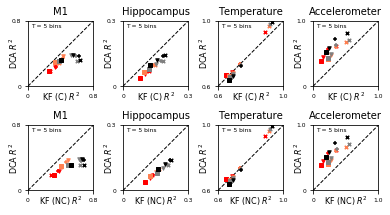

In [14]:
#plot GPFA vs. DCA results

reload(plotting)
fig, axes = plotting.decoding_fix_axes(fig_width=5.5, fig_height=2.7,
                                       wpad_mid=.075, hpad_mid=.2,
                                       wpad_left=.09, wpad_right=.025,
                                       hpad_bot=.12)

loc = "lower right"
bbox_to_anchor = (1.2, -.1)

plotting.scatter_r2_vals(M1_results_fi, 4, dim_vals[0], offset_vals, T_pi_vals, min_val=0, max_val=.8,
                         title='M1', timestep_units='ms', timestep=50, ax=axes[0], pca_label="KF (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(M1_results_sm, 4, dim_vals[0], offset_vals, T_pi_vals, min_val=0, max_val=.8,
                         title='M1', timestep_units='ms', timestep=50, ax=axes[4], pca_label="KF (NC)",
                         legend=False)

plotting.scatter_r2_vals(HC_results_fi, 4, dim_vals[1], offset_vals, T_pi_vals, min_val=0, max_val=.3,
                         title='Hippocampus', timestep_units='ms', timestep=50, ax=axes[1], pca_label="KF (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(HC_results_sm, 4, dim_vals[1], offset_vals, T_pi_vals, min_val=0, max_val=.3,
                         title='Hippocampus', timestep_units='ms', timestep=50, ax=axes[5], pca_label="KF (NC)",
                         legend=False)

plotting.scatter_r2_vals(weather_results_fi, 4, dim_vals[2], offset_vals, T_pi_vals, min_val=.6, max_val=1.,
                         title='Temperature', timestep_units='ms', timestep=50, ax=axes[2], pca_label="KF (C)",
                         legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(weather_results_sm, 4, dim_vals[2], offset_vals, T_pi_vals, min_val=.6, max_val=1.,
                         title='Temperature', timestep_units='ms', timestep=50, ax=axes[6], pca_label="KF (NC)",
                         legend=False)

plotting.scatter_r2_vals(accel_results_fi, 4, dim_vals[3], offset_vals, T_pi_vals, min_val=0, max_val=1.,
                         title='Accelerometer', timestep_units='ms', timestep=50, ax=axes[3], pca_label="KF (C)",
                          legend=False, loc=loc, bbox_to_anchor=bbox_to_anchor, legendtext=False)
plotting.scatter_r2_vals(accel_results_sm, 4, dim_vals[3], offset_vals, T_pi_vals, min_val=0, max_val=1.,
                         title='Accelerometer', timestep_units='ms', timestep=50, ax=axes[7], pca_label="KF (NC)",
                         legend=False)

#plt.savefig("figures/kf_filt_smooth.pdf", bbox_inches="tight")

